决策树可以用于数值型因变量的预测和离散型因变量的分类

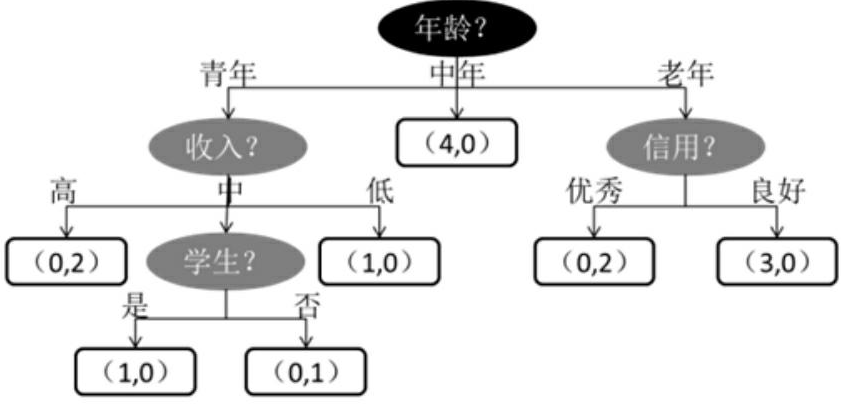

纯净度衡量指标：信息增益、信息增益率、基尼指数

信息增益：信息量越大（分类越不纯净）对应的熵值就越大，反之亦然。事件D的信息增益就是D的信息熵与A事件下D的条件熵之差，事件A对D影响越大，条件熵H（D|A)就会越小

信息熵计算公式：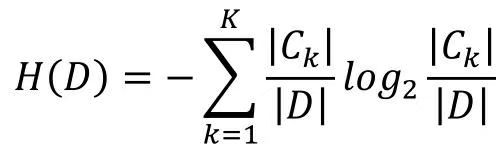

信息增益率公式: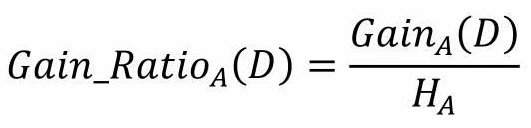

基尼指数计算公式：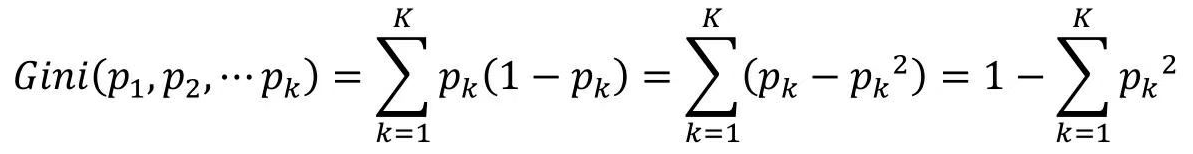

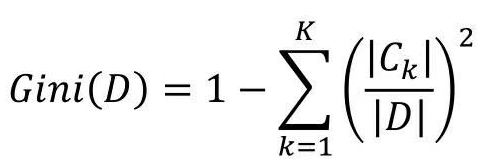

DecisionTreeClassifier和DecisionTreeRegressor类的语法和参数含义

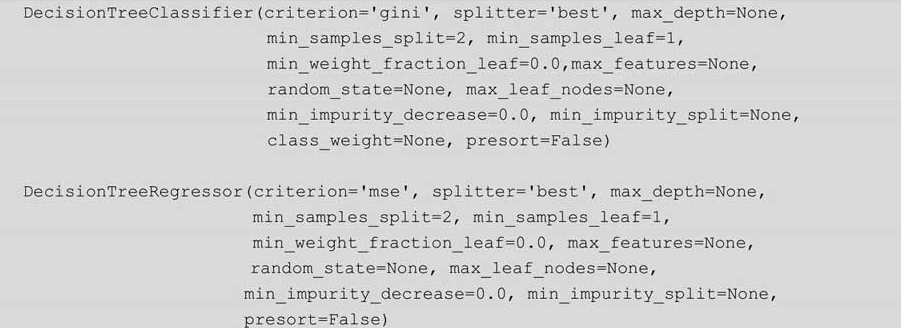

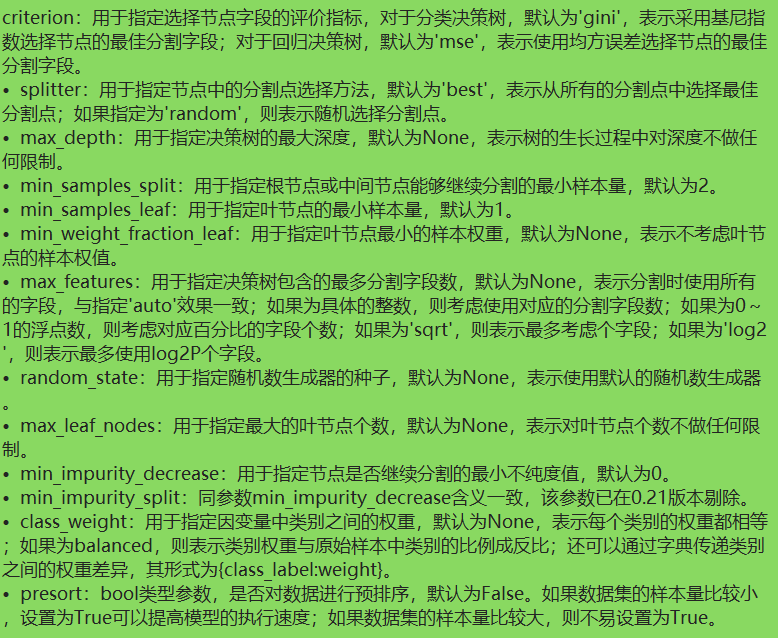

sklearn的ensemble提供了产生随机森林的类RandomForestClassifier

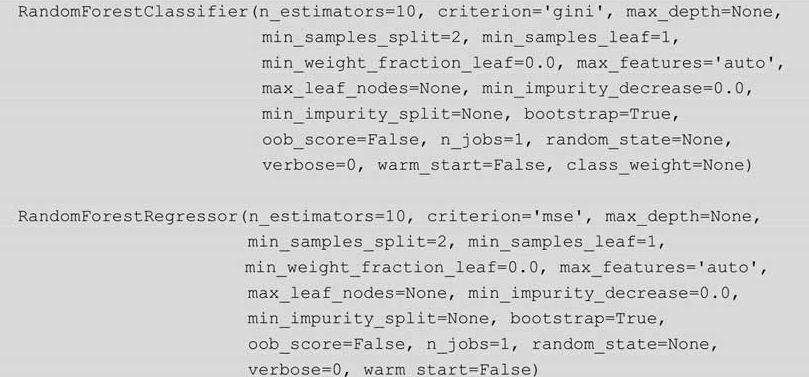

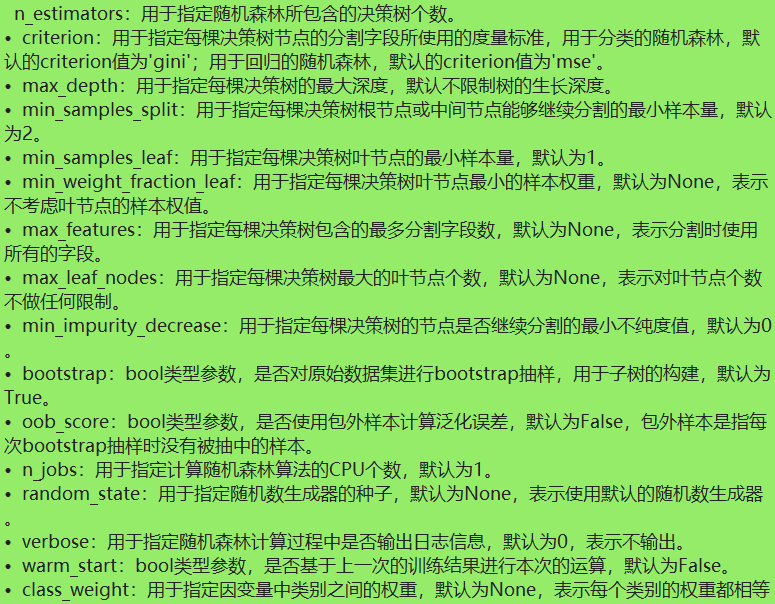

In [1]:
#导入第三方模块
import pandas as pd
Titanic = pd.read_csv("Titanic.csv")

In [2]:
Titanic.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


可以看到PassengerId，Name，Ticket，Cabin没有实际意义可以删掉

Pclass,Sex,Embarked都是离散的分类变量，所以要在建模前重编码（因子化处理/One-Hot编码/哑变量处理）

In [3]:
#删除无意义的变量并检查剩余变量是否有缺失值
Titanic.drop(['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)
Titanic.isnull().sum(axis=0)

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

我们看到Age和Embarked有177和2个缺失值，可以尝试用均值填充或者众数填充

但Age缺的太多了所以不能直接用均值，可以按照性别对缺失的年龄分组填充,但我一直报错，所以还是用均值吧

In [4]:
# 对Sex分组，用各组乘客的平均年龄填充各组中的缺失年龄
Titanic.fillna(value = {'Age':Titanic.Age.mean()},inplace = True)
# 使用Embarked变量的众数填充缺失值
Titanic.fillna(value = {'Embarked':Titanic.Embarked.mode()[0]}, inplace=True)
Titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [5]:
#检查一遍没有空值了
Titanic.isnull().sum(axis=0)

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [6]:
#将数值型的Pclass转换成类别行，否则无法对其哑变量处理
Titanic.Pclass = Titanic.Pclass.astype('category')

#亚变量处理
dummy = pd.get_dummies(Titanic[['Sex','Embarked','Pclass']])

#水平合并Titanic数据集和哑变量的数据集
Titanic = pd.concat([Titanic,dummy],axis=1)

#删除原始的Sex、Embarked和Pclass变量
Titanic.drop(['Sex','Embarked','Pclass'],inplace=True,axis=1)

Titanic.head(5)

,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
2,1,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1,1,0,0
4,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


数据预处理完毕

## 构建决策树模型

In [7]:
from sklearn import model_selection
#取出所有的自变量名
predictors = Titanic.columns[1:]

#拆分为训练集和测试集，训练集占75%，测试集占25%
X_train,X_test,y_train,y_test = model_selection.train_test_split(Titanic[predictors],Titanic.Survived,test_size = 0.25,random_state = 1234)

In [8]:
X_train

,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
170,61.000000,0,0,33.5000,0,1,0,0,1,1,0,0
488,30.000000,0,0,8.0500,0,1,0,0,1,0,0,1
42,29.699118,0,0,7.8958,0,1,1,0,0,0,0,1
410,29.699118,0,0,7.8958,0,1,0,0,1,0,0,1
147,9.000000,2,2,34.3750,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
204,18.000000,0,0,8.0500,0,1,0,0,1,0,0,1
53,29.000000,1,0,26.0000,1,0,0,0,1,0,1,0
294,24.000000,0,0,7.8958,0,1,0,0,1,0,0,1
723,50.000000,0,0,13.0000,0,1,0,0,1,0,1,0


In [9]:
X_test

,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
523,44.000000,0,1,57.9792,1,0,1,0,0,1,0,0
778,29.699118,0,0,7.7375,0,1,0,1,0,0,0,1
760,29.699118,0,0,14.5000,0,1,0,0,1,0,0,1
496,54.000000,1,0,78.2667,1,0,1,0,0,1,0,0
583,36.000000,0,0,40.1250,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
484,25.000000,1,0,91.0792,0,1,1,0,0,1,0,0
96,71.000000,0,0,34.6542,0,1,1,0,0,1,0,0
706,45.000000,0,0,13.5000,1,0,0,0,1,0,1,0
218,32.000000,0,0,76.2917,1,0,1,0,0,1,0,0


In [10]:
y_train

170    0
488    0
42     0
410    0
147    0
      ..
204    1
53     1
294    0
723    0
815    0
Name: Survived, Length: 668, dtype: int64

In [11]:
y_test

523    1
778    0
760    0
496    1
583    0
      ..
484    1
96     0
706    1
218    1
515    0
Name: Survived, Length: 223, dtype: int64

为了防止过拟合，需要对决策树进行预剪枝，可使用网格搜索法快速进行各参数组合下的试错

调用GridSearchCV类，该类存储在model_selection中

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn import tree

In [13]:
#预设各参数的不同选项值
max_depth = [2,3,4,5,6]
min_samples_split = [2,4,6,8]
min_samples_leaf = [2,4,8,10,12]

#将各参数值以字典形式组织起来
parameters = {'max_depth':max_depth,'min_samples_split':min_samples_split,
             'min_samples_leaf':min_samples_leaf}

#网格搜索法，测试不同的参数值
grid_dtcateg = GridSearchCV(estimator = tree.DecisionTreeClassifier(),param_grid = parameters,cv=10)

#模型拟合
grid_dtcateg.fit(X_train,y_train)

#返回最佳组合的参数值
grid_dtcateg.best_params_

{'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 2}

In [14]:
parameters

{'max_depth': [2, 3, 4, 5, 6],
 'min_samples_split': [2, 4, 6, 8],
 'min_samples_leaf': [2, 4, 8, 10, 12]}

经过10重交叉验证的网格搜索，得到各参数的最佳组合值为6，8，2

利用这个参数构建分类决策树

In [15]:
from sklearn import metrics
#构建分类决策树
CART_Class = tree.DecisionTreeClassifier(max_depth = 6,min_samples_split =8, min_samples_leaf = 2)

#模型拟合
decision_tree = CART_Class.fit(X_train,y_train)

#模型在测试集上的预测
pred = CART_Class.predict(X_test)

#模型的准确率
print('模型在测试集的预测准确率:\n',metrics.accuracy_score(y_test,pred))
print('模型在训练集的预测准确率:\n',metrics.accuracy_score(y_train,CART_Class.predict(X_train)))

模型在测试集的预测准确率:
 0.7982062780269058
模型在训练集的预测准确率:
 0.8622754491017964


进一步验证模型在测试集上的预测效果，绘制ROC曲线

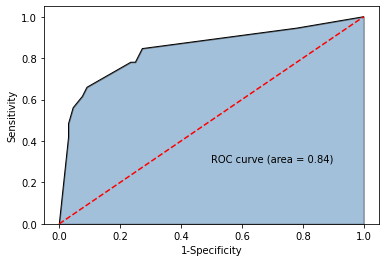

In [16]:
import matplotlib.pyplot as plt

y_score = CART_Class.predict_proba(X_test)[:,1]
fpr,tpr,threshold = metrics.roc_curve(y_test,y_score)

#计算AUC值
roc_auc = metrics.auc(fpr,tpr)
#绘制面积图
plt.stackplot(fpr,tpr,color='steelblue',alpha=0.5,edgecolor='black')

#添加边际线和对角线
plt.plot(fpr,tpr,color = 'black',lw = 1)
plt.plot([0,1],[0,1],color = 'red',linestyle = '--')

#添加文本信息
plt.text(0.5,0.3,'ROC curve (area = %0.2f)'%roc_auc)

#添加x轴和y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.show()

In [17]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from six import StringIO

In [18]:
#绘制决策树
dot_data = StringIO()
export_graphviz(
    decision_tree,
    out_file=dot_data,
    feature_names=predictors,
    class_names=['Unsurvived','Survived'],
    filled=True,
    rounded=True,
    special_characters=True
)

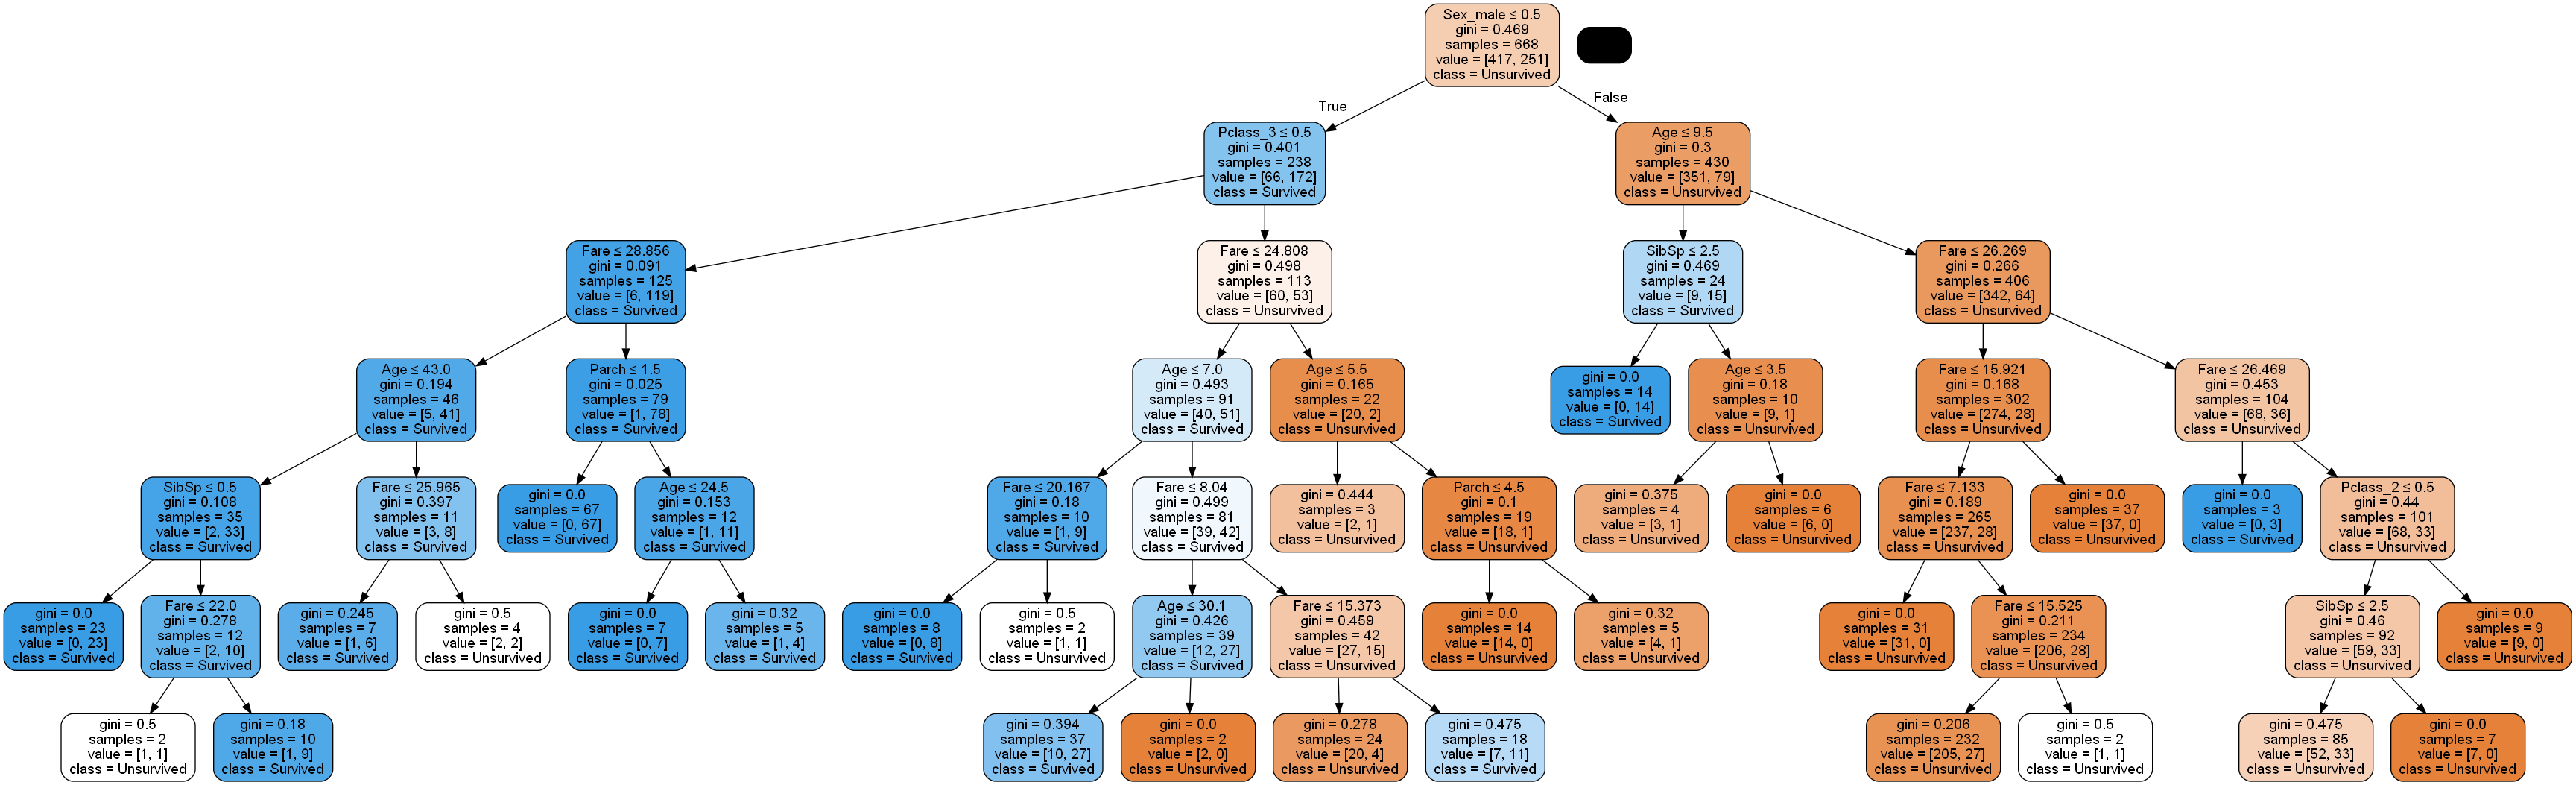

In [19]:
#决策树展现
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## 构建随机森林模型

In [20]:
from sklearn import ensemble

#构建随机森林
RF_class = ensemble.RandomForestClassifier(n_estimators=200,random_state = 1234)

#随机森林的拟合
RF_class.fit(X_train,y_train)

#模型在测试集上的预测
RFclass_pred = RF_class.predict(X_test)

#模型的准确率
print("模型在测试集的预测准确率：\n",metrics.accuracy_score(y_test,RFclass_pred))

模型在测试集的预测准确率：
 0.8161434977578476


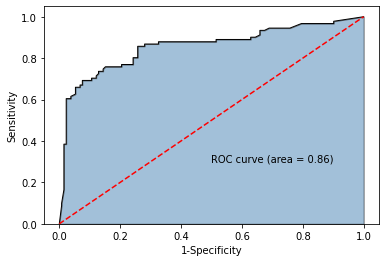

In [21]:
y_score = RF_class.predict_proba(X_test)[:,1]
fpr,tpr,threshold = metrics.roc_curve(y_test,y_score)

#计算AUC值
roc_auc = metrics.auc(fpr,tpr)
#绘制面积图
plt.stackplot(fpr,tpr,color='steelblue',alpha=0.5,edgecolor='black')

#添加边际线和对角线
plt.plot(fpr,tpr,color = 'black',lw = 1)
plt.plot([0,1],[0,1],color = 'red',linestyle = '--')

#添加文本信息
plt.text(0.5,0.3,'ROC curve (area = %0.2f)'%roc_auc)

#添加x轴和y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.show()

利用理想的随机森林算法挑选出影响乘客是否幸存的重要因素

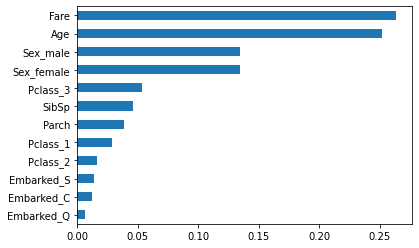

In [22]:
#变量的重要性程度值
importance = RF_class.feature_importances_

#构建含序列用于绘图
Impt_Series = pd.Series(importance,index = X_train.columns)

#对序列排序绘图
Impt_Series.sort_values(ascending = True).plot(kind = 'barh')
plt.show()

# 预测问题解决

此数据集中因变量不是离散的类别值二十连续的数值

In [23]:
NHANES = pd.read_excel('NHANES.xlsx')

In [24]:
NHANES.head()

,age_months,sex,black,BMI,HDL,CKD_stage,S_Creat,cal_creat,meals_not_home,CKD_epi_eGFR
0,472,1,0,30.22,35,0,1.0,1.0,2,94.388481
1,283,1,1,29.98,43,0,1.1,1.1,1,109.086423
2,1011,2,0,24.62,51,0,0.8,0.8,1,67.700441
3,176,2,0,27.28,48,1,0.6,0.6,3,136.861679
4,534,1,0,33.84,37,0,0.9,0.9,2,103.510891


年龄，性别，肤色，BMI指数，高密度脂蛋白指数等，因变量为CKD列

In [25]:
#取出自变量名称
predictors = NHANES.columns[:-1]

In [26]:
#将数据集拆分为训练集和测试集
X_train,X_test,y_train,y_test = model_selection.train_test_split(NHANES[predictors],NHANES.CKD_epi_eGFR,test_size = 0.25,random_state = 1234)

In [27]:
#预设各参数的不同选项值
max_depth = [18,19,20,21,22]
min_samples_split = [2,4,6,8]
min_samples_leaf = [2,4,8,10,12]

#将各参数值以字典形式组织起来
parameters = {'max_depth':max_depth,'min_samples_split':min_samples_split,
             'min_samples_leaf':min_samples_leaf}

#网格搜索法，测试不同的参数值
grid_dtcateg = GridSearchCV(estimator = tree.DecisionTreeRegressor(),param_grid = parameters,cv=10)

#模型拟合
grid_dtcateg.fit(X_train,y_train)

#返回最佳组合的参数值
grid_dtcateg.best_params_

{'max_depth': 22, 'min_samples_leaf': 2, 'min_samples_split': 6}

因为是连续型所以用MSE或RMSE来评估

In [28]:
CART_Reg = tree.DecisionTreeRegressor(max_depth = 20,min_samples_split =2, min_samples_leaf = 4)

#模型拟合
CART_Reg.fit(X_train,y_train)

#模型在测试集上的预测
pred = CART_Reg.predict(X_test)

#计算衡量模型好坏的MSE值
metrics.mean_squared_error(y_test,pred)

2.368170315054571

## 构建回归的随机森林

In [29]:
RF= ensemble.RandomForestRegressor(n_estimators=200,random_state = 1234)

#随机森林的拟合
RF.fit(X_train,y_train)

#模型在测试集上的预测
RF_pred = RF.predict(X_test)

#计算MSE值
metrics.mean_squared_error(y_test,RF_pred)

0.89356110745724

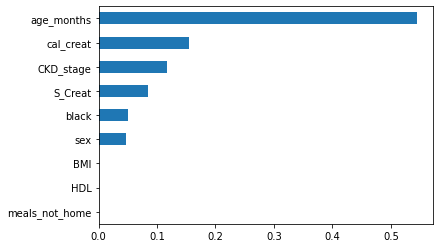

In [30]:
#变量的重要性程度值
importance = RF.feature_importances_

#构建含序列用于绘图
Impt_Series = pd.Series(importance,index = X_train.columns)

#对序列排序绘图
Impt_Series.sort_values(ascending = True).plot(kind = 'barh')
plt.show()